In [2]:
# Cell 1: Install Required Libraries
!pip install -q torchdiffeq scikit-learn pandas matplotlib seaborn torch kaggle

In [3]:
# Cell 2: Import Libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchdiffeq import odeint
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Set device for PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Cell 3: Download and Load Dataset
# Assuming kaggle.json is uploaded to the Colab session root.

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mlg-ulb/creditcardfraud --force
!unzip -o creditcardfraud.zip

df = pd.read_csv('creditcard.csv')

# Features: V1 to V28 (PCA components), Amount
features = ['V' + str(i) for i in range(1, 29)] + ['Amount']
X = df[features]
y = df['Class']  # 0: normal, 1: fraud

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add normalized Time
X_scaled = np.hstack((X_scaled, (df[['Time']].values / df['Time'].max())))

# Split into normal and anomalous
normal_mask = y == 0
anomalous_mask = y == 1
X_normal = torch.tensor(X_scaled[normal_mask], dtype=torch.float32).to(device)
X_anomalous = torch.tensor(X_scaled[anomalous_mask], dtype=torch.float32).to(device)
y_normal = y[normal_mask]
y_anomalous = y[anomalous_mask]

# Subsample normal data for efficiency
subsample_size = 10000  # Adjust as needed
X_normal = X_normal[:subsample_size]
y_normal = y_normal[:subsample_size]

print(f"Normal samples: {len(X_normal)}, Anomalous samples: {len(X_anomalous)}")

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 1.79GB/s]
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          
Normal samples: 10000, Anomalous samples: 492


In [6]:
# Cell 4: Define Neural ODE Components
class ODEFunc(nn.Module):
    def __init__(self, hidden_dim):
        super(ODEFunc, self).__init__()
        input_dim = X_scaled.shape[1]  # 29 features + normalized Time
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, t, y):
        return self.net(y)

class NeuralODE(nn.Module):
    def __init__(self, hidden_dim=64):
        super(NeuralODE, self).__init__()
        self.ode_func = ODEFunc(hidden_dim)

    def forward(self, y0, t):
        pred = odeint(self.ode_func, y0, t, method='rk4')
        return pred

In [7]:
# Cell 5: Train Neural ODE on Normal Data
model = NeuralODE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

num_epochs = 50
batch_size = 256
for epoch in range(num_epochs):
    model.train()
    permutation = torch.randperm(X_normal.size(0))
    epoch_loss = 0
    for i in range(0, X_normal.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x = X_normal[indices]

        t = torch.tensor([0.0, 1.0]).to(device)
        y0 = batch_x

        pred = model(y0, t)
        loss = criterion(pred[-1], y0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / (X_normal.size(0)/batch_size):.9f}")

Epoch [10/50], Loss: 0.000043543
Epoch [20/50], Loss: 0.000014261
Epoch [30/50], Loss: 0.000006680
Epoch [40/50], Loss: 0.000003626
Epoch [50/50], Loss: 0.000002230


In [8]:
# Cell 6: Extract Embeddings using Neural ODE
def get_ode_embeddings(data, model, batch_size=256):
    model.eval()
    with torch.no_grad():
        t = torch.tensor([0.0, 1.0]).to(device)
        evolved = []
        for i in range(0, data.size(0), batch_size):
            batch = data[i:i+batch_size]
            pred = model(batch, t)[-1]
            evolved.append(pred.cpu().numpy())
    return np.vstack(evolved)

normal_embeddings = get_ode_embeddings(X_normal, model, batch_size)
all_data = torch.cat((X_normal, X_anomalous), dim=0)
all_embeddings = get_ode_embeddings(all_data, model, batch_size)
anomalous_embeddings = all_embeddings[len(X_normal):]

In [9]:
# Cell 7: Train Isolation Forest on Embeddings
iso_forest = IsolationForest(contamination=0.001, random_state=42)
iso_forest.fit(normal_embeddings)

# Get anomaly scores (positive values closer to 0 are normal, negative are anomalous)
normal_scores = iso_forest.decision_function(normal_embeddings)
anomalous_scores = iso_forest.decision_function(anomalous_embeddings)
all_scores = np.concatenate((normal_scores, anomalous_scores))
all_labels = np.concatenate((np.zeros(len(normal_scores)), np.ones(len(anomalous_scores))))

In [10]:
# Cell 8: Evaluation
# Threshold: mean - 2*std of normal scores
threshold = np.mean(normal_scores) - 2 * np.std(normal_scores)
predictions = all_scores < threshold

roc_auc = roc_auc_score(all_labels, -all_scores)
precision, recall, _ = precision_recall_curve(all_labels, -all_scores)
pr_auc = auc(recall, precision)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

# Sample Inference
sample_indices = [0, 100, len(all_scores)-1]
for idx in sample_indices:
    score = all_scores[idx]
    flag = "Anomalous" if score < threshold else "Normal"
    print(f"Transaction {idx}: Score={score:.4f}, Flag={flag}, True Label={all_labels[idx]}")

ROC AUC: 0.9808
PR AUC: 0.8077
Transaction 0: Score=0.2592, Flag=Normal, True Label=0.0
Transaction 100: Score=0.2837, Flag=Normal, True Label=0.0
Transaction 10491: Score=0.1996, Flag=Normal, True Label=1.0


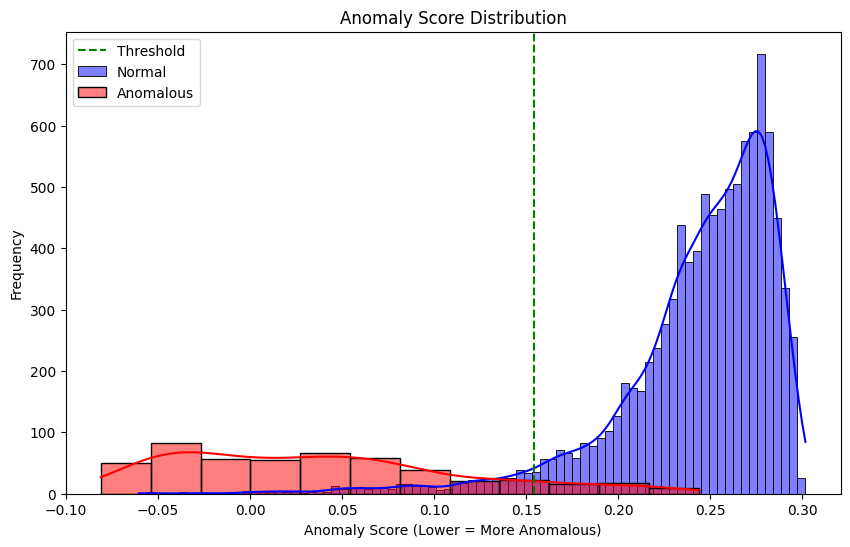

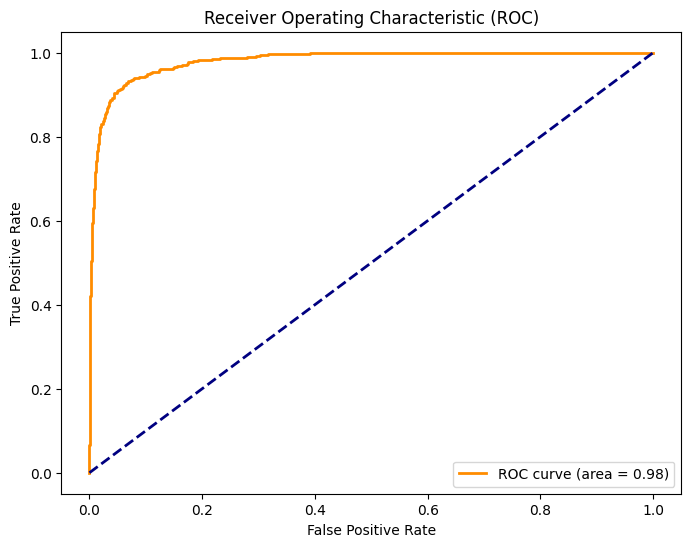

Model training complete! Use the UI below for inference.


In [11]:
# Cell 9: Visualizations
plt.figure(figsize=(10, 6))
sns.histplot(normal_scores, kde=True, color='blue', label='Normal')
sns.histplot(anomalous_scores, kde=True, color='red', label='Anomalous')
plt.axvline(threshold, color='green', linestyle='--', label='Threshold')
plt.title('Anomaly Score Distribution')
plt.xlabel('Anomaly Score (Lower = More Anomalous)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(all_labels, -all_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

print("Model training complete! Use the UI below for inference.")

In [16]:
# Cell 10: Professional Inference UI with ipywidgets

# Import additional modules if needed (add to Cell 2)
from ipywidgets import HTML, Layout, Box
import warnings
warnings.filterwarnings('ignore')  # Optional: Suppress warnings for cleaner output

# Define prediction function (updated to fix scaler warning)
def predict_anomaly(input_str):
    try:
        values = [float(v.strip()) for v in input_str.split(',')]
        if len(values) != 30:
            return "Invalid input: Please provide exactly 30 comma-separated numerical values (Time, V1 to V28, Amount)."

        time = values[0]
        features = values[1:29] + [values[29]]  # V1-V28, Amount
        columns = ['V' + str(i) for i in range(1, 29)] + ['Amount']
        input_df = pd.DataFrame([features], columns=columns)
        features_scaled = scaler.transform(input_df)
        norm_time = time / max_time
        input_scaled = np.hstack((features_scaled, [[norm_time]]))

        input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(device)

        model.eval()
        with torch.no_grad():
            t = torch.tensor([0.0, 1.0]).to(device)
            embedding = model(input_tensor, t)[-1].cpu().numpy()

        score = iso_forest.decision_function(embedding)[0]
        flag = "Anomalous" if score < threshold else "Normal"

        interpretation = (
            f"<b>Prediction:</b> {flag}<br>"
            f"<b>Anomaly Score:</b> {score:.4f} (Scores below the threshold indicate anomalous transactions)<br>"
            f"<b>Threshold:</b> {threshold:.4f}"
        )
        return interpretation, flag
    except ValueError:
        return "Invalid input: All values must be numerical. Please check your input.", "Error"
    except Exception as e:
        return f"Error: {str(e)}. Please verify the input format.", "Error"

# Create widgets with professional styling
title = HTML(
    value='<h2 style="color: #333; margin-bottom: 10px;">Transaction Based Anomaly Detection Interface</h2>'
)

description = HTML(
    value=(
        '<p style="color: #555; font-size: 14px; margin-bottom: 20px;">'
        '<b>Input Format:</b> Enter 30 comma-separated values: Time (in seconds), V1 to V28 (dimensionless PCA features), Amount (in USD).<br>'
        '<b>Example (Normal Transaction):</b> 0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62<br>'
        '<b>Example (Anomalous Transaction):</b> 406,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,3.202033,-2.899907,-0.595222,-4.286254,0.294501,-2.303350,-5.025980,-1.078891,2.050079,1.249158,0.271170,0.929805,-0.122747,0.0033,-0.231809,-0.491873,0.011903,0.035538,56.80'
        '</p>'
    )
)

input_text = widgets.Textarea(
    value='',
    placeholder='Enter 30 comma-separated values here...',
    disabled=False,
    layout=Layout(width='100%', height='100px', margin='0 0 10px 0')
)

output = widgets.HTML(
    value='',
    layout=Layout(border='1px solid #ddd', padding='15px', width='100%', min_height='100px', background_color='#f9f9f9')
)

button = widgets.Button(
    description='Predict Anomaly',
    button_style='primary',
    tooltip='Run prediction on the input data',
    icon='check-circle',
    layout=Layout(width='180px', margin='0 10px 0 0')
)

normal_sample_button = widgets.Button(
    description='Load Normal Sample',
    button_style='info',
    tooltip='Load an example normal transaction',
    icon='file-alt',
    layout=Layout(width='180px', margin='0 10px 0 0')
)

anomalous_sample_button = widgets.Button(
    description='Load Anomalous Sample',
    button_style='warning',
    tooltip='Load an example anomalous transaction',
    icon='exclamation-triangle',
    layout=Layout(width='180px', margin='0 10px 0 0')
)

clear_button = widgets.Button(
    description='Clear',
    button_style='danger',
    tooltip='Clear input and output',
    icon='trash',
    layout=Layout(width='180px')
)

def on_button_clicked(b):
    result, flag = predict_anomaly(input_text.value)
    color = 'red' if flag == 'Anomalous' else 'green' if flag == 'Normal' else 'orange'
    output.value = f'<div style="color: {color}; font-size: 14px;">{result}</div>'

def on_normal_sample_clicked(b):
    sample = '0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62'
    input_text.value = sample
    output.value = '<p style="color: #555; font-size: 14px;">Normal sample loaded. Click "Predict Anomaly" to analyze.</p>'

def on_anomalous_sample_clicked(b):
    sample = '406,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,3.202033,-2.899907,-0.595222,-4.286254,0.294501,-2.303350,-5.025980,-1.078891,2.050079,1.249158,0.271170,0.929805,-0.122747,0.0033,-0.231809,-0.491873,0.011903,0.035538,56.80'
    input_text.value = sample
    output.value = '<p style="color: #555; font-size: 14px;">Anomalous sample loaded. Click "Predict Anomaly" to analyze.</p>'

def on_clear_clicked(b):
    input_text.value = ''
    output.value = ''

button.on_click(on_button_clicked)
normal_sample_button.on_click(on_normal_sample_clicked)
anomalous_sample_button.on_click(on_anomalous_sample_clicked)
clear_button.on_click(on_clear_clicked)

# Assemble the UI
buttons_box = Box([button, normal_sample_button, anomalous_sample_button, clear_button], layout=Layout(display='flex', flex_flow='row', align_items='stretch', margin='10px 0'))

ui = widgets.VBox([
    title,
    description,
    input_text,
    buttons_box,
    HTML('<p style="color: #333; font-size: 14px; margin: 10px 0 5px 0;"><b>Prediction Results:</b></p>'),
    output
], layout=Layout(border='1px solid #eee', padding='20px', width='100%', background_color='#fff', box_shadow='0 2px 4px rgba(0,0,0,0.1)'))

# Display the UI
display(ui)